In [151]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
import pandas as pd
from mesa.time import BaseScheduler
from mpmath import polylog
import sys
from networkx.utils import powerlaw_sequence

Loading BokehJS ...

### Update from copy_3.py file:
+ Change parameter value
+ change graph
+ change status
+ change contact
+ Add social_distancing

<h1 style="color:red">Note: 15th March is the date that the Australian Government enforced the isolation on incoming travellers from the oversee, it means that phase 2 started on this date (in the term of the model, stage 2 - social distancing - starts at step 73)</h1

## Confirmed cases Starting from 25th January

In [152]:
df_confirmed = pd.read_csv(r'D:/notebooks-baseline/datafile/COVID_AU_national_cumulative.csv')

## Transmission Rate

In [153]:
def getbeta(alpha, kappa): 
    beta = polylog(alpha-1, math.exp(-1 / kappa))/(polylog(alpha-2, math.exp(-1 / kappa))-polylog(alpha-1, math.exp(-1 / kappa)))
    return beta

In [154]:
beta = getbeta(2,5)
beta2 = getbeta(2,10)
beta3 = getbeta(2,15)
print("parameter: {0} and duration: {1}".format(beta,1/beta))
print("parameter: {0} and duration: {1}".format(beta2,1/beta2))
print("parameter: {0} and duration: {1}".format(beta3,1/beta3))

parameter: 0.607989487551965 and duration: 1.64476528044332
parameter: 0.328691269615568 and duration: 3.04236860677676
parameter: 0.233008774343887 and duration: 4.2916838767803


## Importation Model Outputs Starting from 1st January

In [155]:
df_importation = pd.read_csv(r'D:/notebooks-baseline/datafile/COVID_importations_travelRestrictions.csv')
file=df_importation['Estimated COVID importations']
file=file.astype('int')
file = np.array(file)
file

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         1,   1,   2,   2,   2,   3,   4,   4,   5,   5,   6,   7,   8,
         9,  11,  13,  13,  15,   9,   9,   8,   8,   8,   7,   6,   6,
         5,   5,   4,   4,   3,   4,   4,   4,   5,   6,   7,   8,  11,
        13,  15,  18,  21,  25,  29,  36,  41,  42,  51,  59,  69,  81,
        96, 111, 130, 151, 175, 202, 223, 262, 294, 331, 375, 424, 469,
       526, 577,  27,  28,  31,  35,  37,  41,  42,  43,  45,  49,  52,
        20,  21,  17,  18,  16,  15,  14,  12,  11,  10,   9,   8,   6,
         5,   5,   5,   5,   5,   5,   4,   4,   5,   5,   5,   4,   5,
         5,   5,   5,   5,   3,   3,   3,   3,   3,   3,   3,   3,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   3,   3,   3,   3,
         3,   2,   3,   3,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   

#### Overide Activation Function to fit with my work

In [156]:
class RandomActivation(BaseScheduler):
    """ A scheduler which activates each agent once per step, in random order,
    with the order reshuffled every step.

    This is equivalent to the NetLogo 'ask agents...' and is generally the
    default behavior for an ABM.

    Assumes that all agents have a step(model) method.

    """

    def step(self, social = False) -> None:
        """ Executes the step of all agents, one at a time, in
        random order.

        """
        self.social = social 
        for agent in self.agent_buffer(shuffled=True):
            agent.step(social)
 
        self.steps += 1
        self.time += 1

In [157]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    RECOVERED = 3 
    QUARANTINED = 4 
    

class CovidAgent(Agent):
    """This is a class of agents living inside the territory of Australia, each of them have been affected by imported agents"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id,model)
        self.state = State.SUSCEPTIBLE 
        self.number_of_contacts = np.random.randint(0,50)
        self.infection_time = 0
        self.incubation_time = 2
        self.recovery_time = 20
        self.rate_infected = 0.52
        self.rate_second_attack = 0.054
        self.quarantine_days = 14 
        self.quarantine_sd = 2 
        self.social = False
    def step(self,social=False):
        """Take a step forwards in time in 2 condition"""
        self.social = social 
        
        self.status(social)
        self.contact()
        
                
        #self.move() #khong quan trong lam 
        
        
        #self.Q_case()
    def move(self):


        possible_steps = [node for node in self.model.grid.get_neighbors(self.pos, include_center=False) if self.model.grid.is_cell_empty(node)]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    
    
    def status(self, social = False):
        """Check infection status 1 if loop for exposed condition and 1 for infected condition"""
        self.social = social #social distancing policy
        if social ==False:
            """
            EXPOSED
            """
            if self.state == State.EXPOSED: 
                tmuy = self.model.schedule.time - self.infection_time
                self.incubation_period = self.model.get_incubation_time()
                if tmuy >= self.incubation_period: 
                    """
                    successrate = 0.54 #rate from droplets research (0.543)
                    infect = np.random.choice([1,0], p=[successrate, 1-successrate])
                    """

                    #if infect == 1: #if v=0 then the transmission contact becomes ineffective 
                    if self.random.random()<0.54:
                        self.state = State.INFECTED
                    else:
                        self.state = State.SUSCEPTIBLE
            """
            INFECTED
            """        
            if self.state == State.INFECTED: 

                self.contact()
                t = self.model.schedule.time -self.infection_time

                if t >= 20:     
                    #successrate = 0.8 
                    #infect = np.random.choice([1,0], p=[successrate, 1-successrate])
                    if self.random.random()<0.8: 
                        self.state = State.RECOVERED

            """
            RECOVERED
            """ 
            if self.state == State.RECOVERED:
                rate = self.rate_second_attack
                infect = np.random.choice([1,0], p=[rate, 1-rate])
                t = self.model.schedule.time -self.infection_time
                if t>self.model.get_recovery_time():
                    if self.random.random()<self.model.rate_second_attack: 
                        self.state = State.SUSCEPTIBLE

            """
            QUARANTINED
            """

            if self.state == State.QUARANTINED: #I am assuming that people confined themselves ulti they feel better
                t = self.model.schedule.time -self.infection_time
                if t> self.model.recovery_days: #people quarantined either become recovered after 14 days or still be confined at their space 
                    success = 0.5 #chua biet 
                    infect = np.random.choice([1,0], p=[success, 1-success])
                    if self.random.random()<success: 
                        self.state = State.RECOVERED
                        
        ###################################
        #                                 #
        #       SECOND STAGE              # : when social distancing applies
        #                                 #
        ###################################
        if social ==True:
            """
            EXPOSED
            """
            if self.state == State.EXPOSED: 
                tmuy = self.model.schedule.time - self.infection_time
                self.incubation_period = self.model.get_incubation_time()
                if tmuy >= self.incubation_period: 
                    successrate = 0.54 #rate from droplets research (0.543)
                    infect = np.random.choice([1,0], p=[successrate, 1-successrate])
                    if self.random.random()<successrate: #if v=0 then the transmission contact becomes ineffective 
                        self.state = State.INFECTED
                    else:
                        self.state = State.QUARANTINED
            """
            INFECTED
            """        
            if self.state == State.INFECTED: 

                self.contact()
                t = self.model.schedule.time -self.infection_time

                if t >= 6: #after 2 days of latent period, patients shows the symptomatic behaviors they'll decide to quarantine    
                    #successrate = 0.8 
                    #infect = np.random.choice([1,0], p=[successrate, 1-successrate])
                    if self.random.random()<0.9: 
                        self.state = State.QUARANTINED
                    else: 
                        self.state = State.INFECTED

            """
            QUARANTINED
            """

            if self.state == State.QUARANTINED: #I am assuming that people confined themselves ulti they feel better
                t = self.model.schedule.time -self.infection_time
                if t> 14: #people quarantined either become recovered after 14 days or still be confined at their space 
                    success = 0.5 #chua biet 
                    infect = np.random.choice([1,0], p=[success, 1-success])
                    if self.random.random()<0.50: #82% of people are recovered after private confinement  
                        self.state = State.RECOVERED
                    else: 
                        self.state = State.INFECTED
                else: 
                    self.state = State.QUARANTINED

            """
            RECOVERED
            """ 
            if self.state == State.RECOVERED:
                rate = self.rate_second_attack
                infect = np.random.choice([1,0], p=[rate, 1-rate])
                t = self.model.schedule.time -self.recovery_time
                if t>self.model.get_recovery_time():
                    if self.random.random()<0.02: 
                        self.state = State.SUSCEPTIBLE
        
            
   
    def contact(self):
        """Find close contacts and infect"""
        """
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.EXPOSED
                    
                    other.incubation_time = self.model.get_incubation_time()
        """
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptile_neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)
        for other in susceptile_neighbors: 
            if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:  
                #if self.random.random() <model.ptrans:
                other.state = State.EXPOSED
                other.infection_time = self.model.schedule.time
                other.incubation_time = self.model.get_incubation_time()
    def isolated(self): 

        if self.state == State.INFECTED:
            self.state = State.QUARANTINED 
            self.quarantine_days = self.model.get_quarantine_time()

                    
            

        """
    
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        for a in susceptible_neighbors:
            if self.random.random() < model.ptrans:
                a.state = State.EXPOSED
                a.incubation_time = self.model.get_incubation_time()
        """

            

In [174]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""

    def __init__(self, N=10, num_agents=7,num_infected=1,pcontact=0.4, ptrans=0.54, avg_node_degree=3, alpha=2,keppa=5,
                 progression_period=3, progression_sd=2, recovery_rate=0.05, recovery_days=20,
                 recovery_sd=2, incubation_time = 6 , incubation_time_sd = 2, rate_infected = 0.5, rate_second_attack=0.534,quarantine_days=14,quarantine_sd=2):
        #My shit here:
        self.num_nodes = N  
        self.pcontact=pcontact
        self.num_agents= num_agents
        self.alpha = alpha
        self.keppa = keppa 
        """All parameters"""
        prob = avg_node_degree / self.num_nodes
        self.rate_second_attack = rate_second_attack
        self.initial_outbreak_size = 1
        self.incubation_time = incubation_time
        self.incubation_time_sd = incubation_time_sd
        self.rate_infected = rate_infected
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.recovery_rate = recovery_rate
        self.recovery_days = recovery_days
        self.quarantine_days = quarantine_days
        self.quarantine_sd = quarantine_sd
        
        
        self.meta = self.create_net(self.alpha, self.keppa)
        #create network here: 
        self.G = nx.configuration_model(self.meta, create_using=nx.Graph())
        self.grid = NetworkGrid(self.G)

        self.schedule = RandomActivation(self) #activate the step of Agents in random orders
        self.running = True
        #self.dead_agents = []
        """2 types of agents: intra-agent and out-agent"""
        H=np.array(self.grid.G.nodes())
        self.list_of_random_nodes = self.random.sample(self.G.nodes(), self.num_agents)
        self.m=[element for element in H if element not in self.list_of_random_nodes]        
        for i in range(self.num_agents):
            a = CovidAgent(self.list_of_random_nodes[i], self)
            self.schedule.add(a)
            a.state=State.SUSCEPTIBLE
            # Add the agent to a random node
       
            self.grid.place_agent(a,self.list_of_random_nodes[i])
        
        
        
        #add agent
        #self.create_agents()
        """
        infected = np.random.choice([0,1], p=[0.98,0.02])
        if infected == 1:
            a.state = State.INFECTED
            a.recovery_time = self.get_recovery_time()
        """
            
            

        self.datacollector = DataCollector(            
            agent_reporters={"State": 'state'})
    def getbeta(self, alpha, kappa): 
        beta = polylog(alpha-1, math.exp(-1 / kappa))/(polylog(alpha-2, math.exp(-1 / kappa))-polylog(alpha-1, math.exp(-1 / kappa)))
        return beta
    def create_net(self, alpha,keppa): 
        a = powerlaw_sequence(self.num_nodes, alpha)
        a = np.array(a)
        a = a.astype('int64')
        return a  
        
    def powerlawcutoff(self,alpha,kappa):
        """
        parameter n: number of nodes to be included in the array
        parameter k: degree of a node 
        parameter alpha: shape paramater 
        parameter kappa: cut-off exponent 
        """
        p = (random.paretovariate(alpha)*math.exp((random.paretovariate(alpha))/kappa))/(polylog(alpha, math.exp(-1 / kappa)))       
        return p 
        
    def create_agents(self): 

        for i in range(self.new):
            self.rn = self.random.choice(self.m)
            a = CovidAgent(self.rn, self)
            self.schedule.add(a)
            a.state=State.INFECTED
            self.grid.place_agent(a, self.rn)
            a.status()
            a.contact()
            # Create intra-agents
            self.m.remove(self.rn)
    def create_agents_second(self): 

        for i in range(self.new):
            self.rn = self.random.choice(self.m)
            b = CovidAgent(self.rn, self)
            self.schedule.add(b)
            b.state=State.QUARANTINED
            self.grid.place_agent(b, self.rn)
            b.status()
            
            self.m.remove(self.rn)
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    def get_quarantine_time(self):
        return int(self.random.normalvariate(self.quarantine_days,self.quarantine_sd))
    def get_incubation_time(self):
        return int(self.random.normalvariate(self.incubation_time, self.incubation_time_sd))
    def step(self, new =1, second_phase=False, social = False):
        #Câu chuyện ở đây là ông cần phải có grid thì mới có agent để add vô, nếu chỉ có add_nodes thì nó quá đơn thuần và không có agent
        self.new = new
        self.second_phase = second_phase
        self.social = social 
        if new == 0: 
            print(self.schedule.time)
        else:
            if second_phase==False:
                self.create_agents()
            if second_phase==True:
                self.create_agents_second()
                
        self.datacollector.collect(self)
        self.schedule.step(social)
        

        

In [168]:
from mesa.datacollection import DataCollector
N=5000

model = NetworkInfectionModel(N,num_agents=50, ptrans=0.54, rate_second_attack = 0.534, incubation_time=5, recovery_days=20)
steps = 100
print(file)
for i in range(steps):
    if i<50:
        model.step(new=file[i], second_phase=False)
    elif i>=50 and i<75: 
        model.step(new=file[i], second_phase=True,social=True)
    else:
        model.step(second_phase=True,social=True)

model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

[  0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   2   2   2
   3   4   4   5   5   6   7   8   9  11  13  13  15   9   9   8   8   8
   7   6   6   5   5   4   4   3   4   4   4   5   6   7   8  11  13  15
  18  21  25  29  36  41  42  51  59  69  81  96 111 130 151 175 202 223
 262 294 331 375 424 469 526 577  27  28  31  35  37  41  42  43  45  49
  52  20  21  17  18  16  15  14  12  11  10   9   8   6   5   5   5   5
   5   5   4   4   5   5   5   4   5   5   5   5   5   3   3   3   3   3
   3   3   3   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   3   3   3   3   3   2   3   3   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   3   2]
0
1
2
3
4
5
6
7
8
9
10
11


In [169]:
agent_df

State
Step AgentID       
0    4184         0
     2034         0
     4701         0
     1503         0
     3402         0
...             ...
99   620          3
     1595         3
     4227         3
     3715         2
     3037         4

[99639 rows x 1 columns]

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["blue", "orange", "red",])

def plot_grid(model,fig,layout='spring',title='Covid'):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    colors = [cmap(i) for i in states]

    nx.draw(graph, pos, node_size=100, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax,with_labels=True)
    ax.set_title(title)
    return
steps=10
fig,ax=plt.subplots(1,1,figsize=(16,10))

model = NetworkInfectionModel(100,num_agents=50, ptrans=0.1)

model.step()
f=plot_grid(model,fig,layout='spring',title="Covid Transmission")

In [175]:
import pandas as pd
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Infected','Recovered','Quarantined']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f
pop=8000
steps=50
st=time.time()
model = NetworkInfectionModel(pop,num_agents=5000,ptrans=0.54, rate_second_attack = 0.534, incubation_time=5, recovery_days=20)
for i in range(200):
    if i<50:                                                          #first phase 
        model.step(new=file[i], second_phase=False,social=False)
    elif i>=50 and i<75:                                              #second phase is when travel restriction policy is imposed 
        model.step(new=file[i], second_phase=True,social=False)
    else:                                                             #third phase is when social distancing is imposed
        model.step(second_phase=True,social=True)
print("Running time:{}".format(time.time()-st))
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))
print("___________________")
print(file)

0
1
2
3
4
5
6
7
8
9
10
11
Running time:42.76128554344177
      Susceptible  Exposed  Infected  Recovered  Quarantined
Step                                                        
0            5000        0         0          0            0
1            5000        0         0          0            0
2            5000        0         0          0            0
3            5000        0         0          0            0
4            5000        0         0          0            0
...           ...      ...       ...        ...          ...
195          5079       68        49       2460          183
196          5126       61        43       2425          185
197          5160       54        35       2394          198
198          5196       53        57       2373          163
199          5222       56        52       2352          161

[200 rows x 5 columns]
___________________
[  0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   2   2   2
   3   4   4   5   5   6   7   8 

Text(50, 1000, '2nd phase')

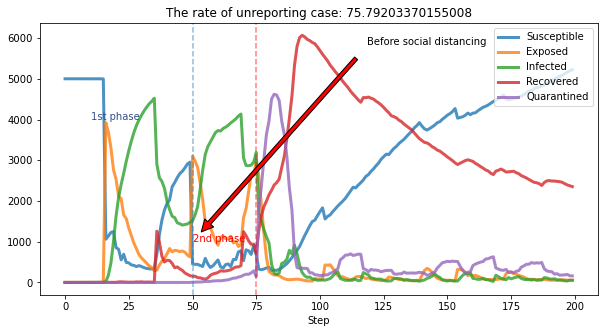

In [176]:
%matplotlib inline

f,ax=plt.subplots(1,1,figsize=(10,5))
plot_states(model,ax)
plt.title("The rate of unreporting case: {0}".format(100 -(801100/get_column_data(model)['Infected'].sum())-20))
plt.legend(loc='upper right')
ax.annotate('Before social distancing',
            xy=(50,1000), xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
ax.axvline(x=50, linestyle='dashed', alpha=0.5)
ax.text(x=10, y=4000, s='1st phase', alpha=1, color='#334f8d')

ax.axvline(x=75, linestyle='dashed', alpha=0.5, color="red")
ax.text(x=50, y=1000, s='2nd phase', alpha=1, color='red')




In [181]:
def run_model(pop, ptrans, degree, steps, delay, layout):

    model = NetworkInfectionModel(pop,N=3000, ptrans=ptrans, avg_node_degree=degree)

    #fig,ax=plt.subplots(1,1,figsize=(10,8))
    fig1 = plt.Figure(figsize=(8,6))
    #ax1=fig1.add_subplot(1,1,1,label='a')
    grid_pane.object = fig1
    fig2 = plt.Figure(figsize=(8,6))
    ax2=fig2.add_subplot(1,1,1,label='b')
    states_pane.object = fig2 

    for i in range(steps):
        model.step()
        plot_grid(model,fig1,title='step=%s' %i, layout=layout)        
        grid_pane.param.trigger('object')
        ax2.clear()
        plot_states(model,ax2)
        ax2.set_xlim(0,steps)
        #states_pane.object = fig2
        states_pane.param.trigger('object')    
        time.sleep(delay)
    plt.clf()
    
#run_model(50, 20, 1, 20, 1)
grid_pane = pn.pane.Matplotlib()
states_pane = pn.pane.Matplotlib()
go_btn = pnw.Button(name='run',width=100,button_type='primary')
pop_input = pnw.IntSlider(name='population',value=100,start=10,end=1000,step=10,width=100)
ptrans_input = pnw.FloatSlider(name='prob. trans',value=0.1,width=100)
degree_input = pnw.IntSlider(name='node degree',value=3,start=1,end=10,width=100)
steps_input = pnw.IntSlider(name='steps',value=20,start=5,end=100,width=100)
delay_input = pnw.FloatSlider(name='delay',value=.2,start=0,end=3,step=.2,width=100)
layout_input = pnw.Select(name='layout',options=['spring','circular','kamada-kawai'],width=100)
widgets = pn.WidgetBox(go_btn,pop_input,ptrans_input,degree_input,steps_input,delay_input,layout_input)

def execute(event):
    run_model(pop_input.value, ptrans_input.value, degree_input.value, steps_input.value, delay_input.value, layout_input.value)
go_btn.param.watch(execute, 'clicks')
    
pn.Row(pn.Column(widgets),grid_pane,states_pane,sizing_mode='stretch_width')

Traceback (most recent call last):
 File "C:\Users\Acer\anaconda3\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\Acer\anaconda3\lib\site-packages\panel\viewable.py", line 258, in _on_msg
 patch.apply_to_document(doc, comm.id)
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
 doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\document\document.py", line 1169, in _with_self_as_curdoc
 return f()
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in <lambda>
 doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\document\document.py", line 397, in apply_json_patch
 self._trigger_on_message(event_json["msg_type"], event_json["msg_data"])
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\document\document.py", line 686, in _trigger_on_message
 cb(msg_data)
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\document\document.py", line 355, in apply_json_event
 model._trigger_event(event)
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\util\callback_manager.py", line 85, in _trigger_event
 self._document._with_self_as_curdoc(invoke)
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\document\document.py", line 1169, in _with_self_as_curdoc
 return f()
 File "C:\Users\Acer\anaconda3\lib\site-packages\bokeh\util\callback_manager.py", line 74, in invoke
 callback(event)
 File "C:\Users\Acer\anaconda3\lib\site-packages\panel\widgets\button.py", line 108, in _server_click
 self._change_event(doc)
 File "C:\Users\Acer\anaconda3\lib\site-packages\panel\reactive.py", line 204, in _change_event
 self._process_events(events)
 File "C:\Users\Acer\anaconda3\lib\site-packages\panel\reactive.py", line 187, in _process_events
 self.param.set_param(**self._process_property_change(events))
 File "C:\Users\Acer\anaconda3\lib\site-packages\param\parameterized.py", line 1472, in set_param
 self_._batch_call_watchers()
 File "C:\Users\Acer\anaconda3\lib\site-packages\param\parameterized.py", line 1611, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\Acer\anaconda3\lib\site-packages\param\parameterized.py", line 1573, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "<ipython-input-181-5c782d9b4217>", line 38, in execute
 run_model(pop_input.value, ptrans_input.value, degree_input.value, steps_input.value, delay_input.value, layout_input.value)
 File "<ipython-input-181-5c782d9b4217>", line 3, in run_model
 model = NetworkInfectionModel(pop,N=3000, ptrans=ptrans, avg_node_degree=degree)
TypeError: __init__() got multiple values for argument 'N'

Row(sizing_mode='stretch_width')
    [0] Column
        [0] WidgetBox
            [0] Button(button_type='primary', name='run', width=100)
            [1] IntSlider(end=1000, name='population', start=10, step=10, value=100, value_throttled=100, width=100)
            [2] FloatSlider(name='prob. trans', value=0.1, value_throttled=0.1, width=100)
            [3] IntSlider(end=10, name='node degree', start=1, value=3, value_throttled=3, width=100)
            [4] IntSlider(end=100, name='steps', start=5, value=20, value_throttled=20, width=100)
            [5] FloatSlider(end=3, name='delay', step=0.2, value=0.2, value_throttled=0.2, width=100)
            [6] Select(name='layout', options=['spring', 'circular', ...], value='spring', width=100)
    [1] Matplotlib(None)
    [2] Matplotlib(None)

In [76]:
mean=[]
de = []
for i in range(len(model.G.degree())):
    m = model.G.degree[i]*0.54
    mean.append(m)
    de.append(model.G.degree[i])

73.599393619826

In [81]:
model.G.degree[10]

6

In [116]:
np.sum(mean)/len(mean) #R0 

1.61487

In [ ]:
rnodes = random.sample(G.nodes(), num_agents)

In [180]:
model.G.degree()

DegreeView({0: 2, 1: 1, 2: 4, 3: 2, 4: 1, 5: 2, 6: 1, 7: 3, 8: 5, 9: 1, 10: 1, 11: 3, 12: 5, 13: 1, 14: 1, 15: 5, 16: 1, 17: 51, 18: 1, 19: 2, 20: 2, 21: 4, 22: 1, 23: 1, 24: 4, 25: 1, 26: 1, 27: 4, 28: 1, 29: 1, 30: 3, 31: 1, 32: 4, 33: 1, 34: 1, 35: 4, 36: 2, 37: 1, 38: 3, 39: 10, 40: 1, 41: 1, 42: 1, 43: 4, 44: 6, 45: 1, 46: 1, 47: 3, 48: 1, 49: 2, 50: 1, 51: 1, 52: 1, 53: 1, 54: 2, 55: 2, 56: 2, 57: 4, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 3, 65: 3, 66: 1, 67: 1, 68: 7, 69: 1, 70: 2, 71: 2, 72: 1, 73: 1, 74: 1, 75: 1, 76: 4, 77: 2, 78: 1, 79: 2, 80: 2, 81: 1, 82: 2, 83: 2, 84: 2, 85: 2, 86: 1, 87: 1, 88: 1, 89: 3, 90: 1, 91: 1, 92: 1, 93: 3, 94: 1, 95: 1, 96: 2, 97: 1, 98: 1, 99: 1, 100: 1, 101: 2, 102: 2, 103: 3, 104: 1, 105: 1, 106: 1, 107: 5, 108: 1, 109: 1, 110: 1, 111: 1, 112: 3, 113: 1, 114: 1, 115: 3, 116: 1, 117: 1, 118: 1, 119: 1, 120: 2, 121: 1, 122: 1, 123: 5, 124: 1, 125: 1, 126: 1, 127: 3, 128: 1, 129: 3, 130: 2, 131: 1, 132: 4, 133: 1, 134: 1, 135: 2, 136: 2, 

In [ ]:
nx.draw(G,with_labels=True)

KeyboardInterrupt: 

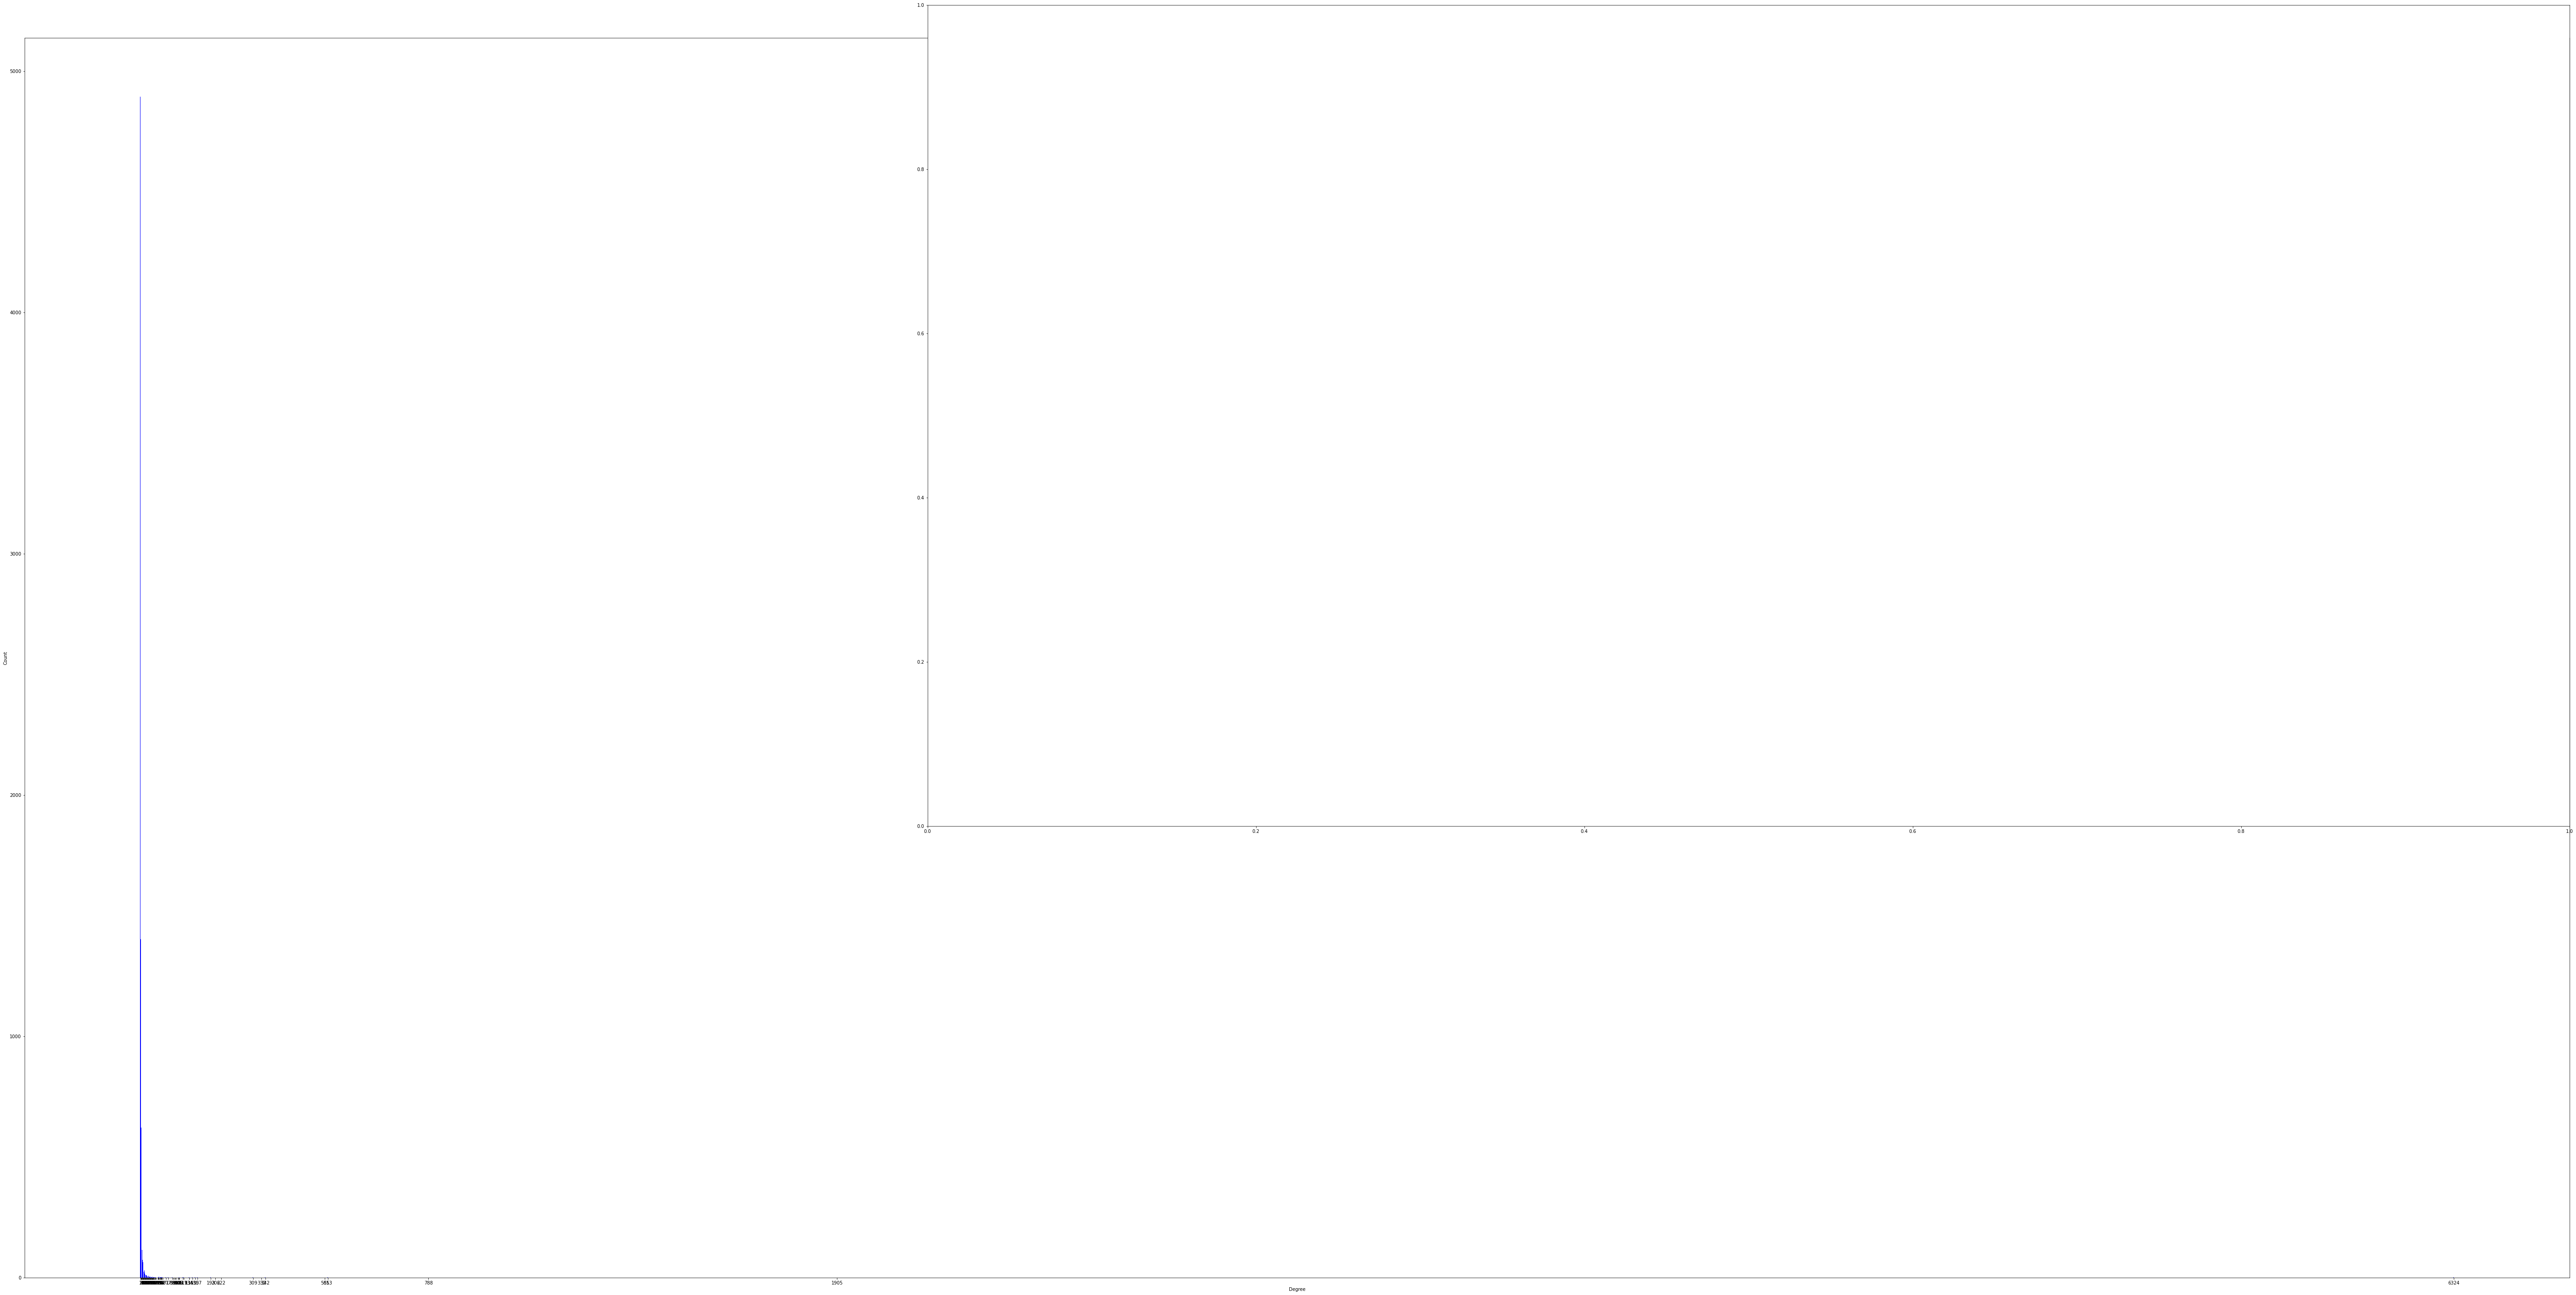

In [182]:
plt.ion()
from itertools import combinations, groupby
import collections
#Degree Distribution
degree_sequence = sorted([d for n, d in model.G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(100,50))
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = model.G.subgraph(sorted(nx.connected_components(model.G), key=len, reverse=True)[0])
pos = nx.spring_layout(model.G)
plt.axis("off")
nx.draw_networkx_nodes(model.G, pos, node_size=20)
nx.draw_networkx_edges(model.G, pos, alpha=0.4)
plt.show()

(array([7.998e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.94090e+04, 3.88170e+04, 5.82250e+04, 7.76330e+04,
        9.70410e+04, 1.16449e+05, 1.35857e+05, 1.55265e+05, 1.74673e+05,
        1.94081e+05]),
 <a list of 10 Patch objects>)

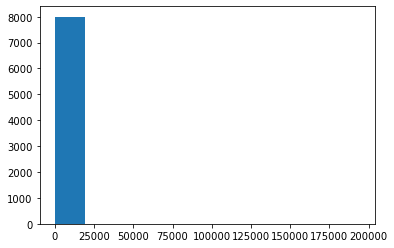

In [193]:
plt.hist(model.meta)

In [20]:
print(model.schedule.time)

73


In [53]:
np.random.choice([1,0], p=[0.5, 0.5])

0

In [16]:
random.random()

0.3326957860631705

In [58]:
p=CutoffPowerLaw(2,10)

In [59]:
p(5)

mpf('0.018489118676580686')

In [54]:
pow((5+0.0),-2)

0.04

In [65]:
import numpy
g = gennet(100, p)

NameError: name 'networkx' is not defined

In [63]:
g

(100, <function __main__.CutoffPowerLaw.<locals>.p(k)>)